In [1]:
import numpy as np

In [4]:
# based traits
traits = {'age' : None,
          'gender' : None,
          'race' : None,
          'mental disorder' : None,
          'medical disorder' : None,
          'suport factor' : None}

In [23]:
import pandas as pd

# Your data
data = {
    "year": [2021, 2022, 2023],
    "0-18": [0.000017, 0.000021, 0.000020],
    "19-29": [0.000162, 0.000155, 0.000164],
    "30-39": [0.000164, 0.000171, 0.000181],
    "40-49": [0.000163, 0.000152, 0.000174],
    "50-59": [0.000192, 0.000187, 0.000183],
    "60-69": [0.000165, 0.000167, 0.000167],
    "70-79": [0.000138, 0.000135, 0.000128],
    "80+": [0.000167, 0.000160, 0.000142]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Calculating the mean of the rows
mean_row = df.mean(axis=0)
mean_row


year     2022.000000
0-18        0.000019
19-29       0.000160
30-39       0.000172
40-49       0.000163
50-59       0.000187
60-69       0.000166
70-79       0.000134
80+         0.000156
dtype: float64

GENERAL INFO

2021 --> suicides: 5201, people: 37907704

2022 --> suicides: 5108, people: 37766327

2023 --> suicides: 5233, people: 37636508


mean --> suicides: 5181, people: 37770180

In [18]:
x, y, z = 69, 62, 94
np.mean([ x/ 5201, y/5108, x/5233 ]), np.mean( [x/37907704 , y/37766327, z/37636508] )

(0.012863351909124757, 1.986486505003774e-06)

* liczba osob uzaleznionych od narkotykow na 2018 rok jest szacowana na 60k osob czyli mniej wiecej 0.015914359526600853 populacji

* celebrytom zostawiamy taka sama szanse na samobojstwo

In [21]:
####### PERCENTAGE IN POLISH POPULATION
# gender(male),     0.4831054
# celeb,            10**(-5)
# alcoholic,        0.0652236
# drugs             0.01591436
# disabled          0.1064498
# psychiatric       0.0529572
traits_prob_binary = [0.4831054, 10**(-4), 0.00652236, 0.01591436, 0.1064498, 0.0529572]

In [ ]:
####### PERCENTAGE IN SUICIDES
# gender(male),             0.8414182056864247
# celeb,                    ---
# naduzywal alkoholu,       0.17173296042285421
# drugs                     0.012863351909124757
# disabled
# psychiatric               0.2031140342952613

In [ ]:
####### WHAT % OF WHOLE POPULATION COMMITTED SUICIDE
# gender(male),         11.541791657682138e-05
# gender (female)       2.1738274374281176e-05
# celeb,                ---
# naduzywal alkoholu,   2.355429068952505e-05  
# drugs                 1.986486505003774e-06
# disabled
# psychiatric           2.8623455816620343e-05

Po pierwsze trzeba zdefiniować, jak będzie chcieli pogrupować społeczności (znajomych) względem agenta. Albo na sztywno robimy "patch", które będą oznaczać naszą społeczność, albo robimy jakiś clustering (ale nie brałbym wszystkich), albo jeszcze inny sposób.

Podstawowy sposób w jaki się generuje samobójstwa to bierze się wartości cech, dla każdej cechy ustala się wartość graniczną (threshold), której po przekroczeniu zwiększa się ryzyko popełnienia samobójstwa dla danej cechy. Czyli {1 - q, 1 + q}, gdzie q to ustalona wartość. 

Czyli parwdopodobieństwo popełnienia samobójstwa będzie równe 

$$ p_{new} = p_{old}\cdot\prod_{i=1}^{6}(1 \pm q_i)$$




Keywords:
- social learning

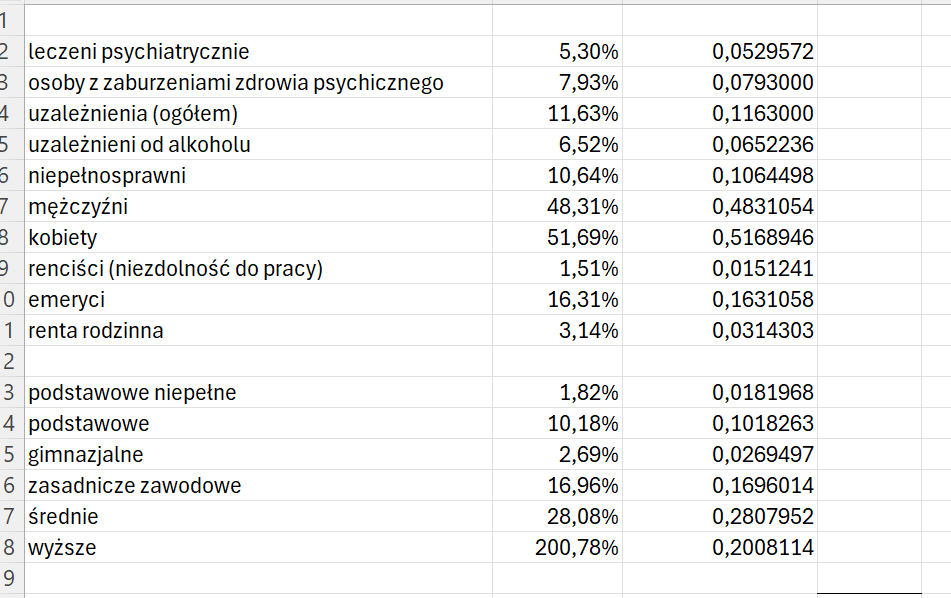

In [37]:
class Community:

    def __init__(self, M, stats, q = .2):
        # M is size of patch
        self.M = M
        self.q = q
        self.patch = np.zeros(shape = (M, len(stats) + 2), dtype=object) # community patch
        self.stats = stats # teraz zakładam, że te staty dla agentów są stałe, i tylko na początku są losowane

    def _agents_stats(self, stats_prob_binary):
        # draw binary stats according to stats_prob array
        # TODO dodac czynnik losowy
        return np.array([1.1 * 10**(-5)] + [1 if np.random.uniform()<prob else 0 for prob in stats_prob_binary])
    
    def _fill_community(self):
        # add agent to community
        for i in range(self.M):
            self.patch[i] = self._agents_stats(self.stats)
    
    def _suicide_status(self):
        suicidal_in = []
        suicidal_cele = []
        suicidal_index = []
        suicide_prob = lambda stats, q : min(stats[0] * np.prod([1 + q if stat == 1 else 1 - q for stat in stats[2:]]),1)
        for i in range(self.M):
            self.patch[i][0] = suicide_prob(stats = self.patch[i], q = self.q)
            #print(self.patch[i][0])
            # the talk about suicidal within 3 past time ticks, but i dont get it.
            if np.random.binomial(1,self.patch[i][0]) == 1:
                suicidal_index.append(i) 
                if self.patch[i][0] == 0:
                    suicidal_in.append([i,self.patch[i][1:]])
                else:
                    suicidal_cele.append([i,self.patch[i][1:]])
        
        return suicidal_in, suicidal_cele, suicidal_index
    
    def _copycat_suicide(self, celebrities = [], suicidal = [], index = []):
        suicidal = suicidal + celebrities 
        if len(suicidal) > 0:
            print(len(suicidal))
            for j in range(self.M):
                xn = []
                xs = []

                for _, stats in suicidal:

                    m = np.sum(self.patch[j, 2:] == stats[1:])
                    if stats[0] == 0:
                        # from book, the suicide of normal agents impact community have value 1.5
                        xn.append(1.01 ** (m ** 2) * 1.5)
                    else:
                        # from book, the suicide of celebrities agents impact community have value 8
                        xs.append(1.01 ** (m ** 2) * 8)
                    
                self.patch[j][0] = min(self.patch[j][0] * (1 + sum(xn) + sum(xs)),1)   
                
            for ind in index:
                self.patch[ind] = self._agents_stats(self.stats)
                
    def _simulation(self,steps):
        
        self._fill_community()
        
        for _ in range(steps):
            suicide_in, suicidal_cele, index = self._suicide_status()
            self._copycat_suicide(suicide_in, suicidal_cele, index)
            #print("="*40)

In [41]:
class World:

    def __init__(self, N, M , stats):
        self.N = N
        self.M = M
        self.stats = stats
        self.word_suicidal = np.zeros(shape = (M,M))
        self.communities = np.empty(shape =(M,M),dtype=object)
        self.celebrities_suicide = []
    
    def __init_communities__(self):

        for i in range(self.M):
            for j in range(self.M):
                
                self.communities[i, j] = Community(self.N,self.stats, q = 0.2)
                self.communities[i, j]._fill_community()

    def __suicide_status__(self):
        suicidal_celebrities = []
        suicidal_ins = np.empty(shape =(self.M,self.M),dtype=object)
        for i in range(self.M):
            for j in range(self.M):

                suicide_in, suicidal_cele, index = self.communities[i,j]._suicide_status()
                suicidal_celebrities.extend(suicidal_cele)
                suicidal_ins[i,j] = [suicide_in, index]
                self.word_suicidal[i,j] = len(index)

        for i in range(self.M):
            for j in range(self.M): 
                self.communities[i, j]._copycat_suicide(suicidal_ins[i,j][0], suicidal_celebrities, suicidal_ins[i,j][1])

    def __simulation__(self,steps):
        word_times = []
        self.__init_communities__()
        for _ in range(steps):
            self.__suicide_status__()
            word_times.append(self.word_suicidal)
            self.word_suicidal = np.zeros_like(self.word_suicidal)
            print(_)

        return word_times


In [26]:
community = Community(100, [0.774, 0.483, 0.767, 0.186, 0.1, 0.2])
community._simulation(60)

In [44]:
# nie odpalać z powodu dużej ilości samobójstw
class1 = World(50,10,[0.774, 0.483, 0.767, 0.186, 0.1, 0.2])
xd = class1.__simulation__(60)

0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 